## 1. Quá trình dự báo trên mô hình LSTM

Thêm thư viện

In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.models import load_model
import investpy
import datetime as dt

Nạp dữ liệu từ file csv

In [10]:

start = '01/06/2021'
end = dt.datetime.now().strftime("%d/%m/%Y")
stock='bitcoin'
df = investpy.get_crypto_historical_data(crypto=stock,from_date=start, to_date=end)
df = pd.DataFrame(df)
df

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2021-06-01,37294.3,37850.3,35742.7,36687.6,113478,USD
2021-06-02,36687.7,38199.9,35981.1,37555.8,96889,USD
2021-06-03,37555.7,39462.3,37193.6,39187.3,106442,USD
2021-06-04,39191.4,39255.4,35659.9,36851.3,127708,USD
2021-06-05,36841.2,37887.6,34832.0,35520.0,101475,USD
...,...,...,...,...,...,...
2022-06-11,29083.3,29426.6,28161.8,28403.4,82917,USD
2022-06-12,28404.0,28534.8,26606.3,26606.3,120024,USD
2022-06-13,26606.3,26857.6,22006.3,22448.0,379257,USD


Chuẩn hóa dữ liệu

In [11]:
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
# Đường Simple Moving Average (SMA)
# là đường trung bình động đơn giản được tính bằng trung bình cộng các mức giá đóng cửa trong một khoảng thời gian giao dịch nhất định.
# Vd MA_7 = Khoảng thời gian (7 ngày về sau tính cả ngày đang tính)
df[f'SMA_{ma_1}'] = df['Close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['Close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['Close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['Close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['Close'].rolling(window=ma_3).std()
df.dropna(inplace=True)

df.to_csv(f"{stock}.csv")
print(df)

               Open     High      Low    Close  Volume Currency     H-L  \
Date                                                                      
2021-06-21  35597.9  35708.4  31284.1  31692.0  256872      USD  4424.3   
2021-06-22  31682.7  33272.5  28901.8  32496.4  309654      USD  4370.7   
2021-06-23  32498.3  34784.3  31736.5  33674.3  173340      USD  3047.8   
2021-06-24  33678.1  35249.9  32356.7  34665.8  119250      USD  2893.2   
2021-06-25  34660.5  35490.9  31337.9  31594.0  193433      USD  4153.0   
...             ...      ...      ...      ...     ...      ...     ...   
2022-06-11  29083.3  29426.6  28161.8  28403.4   82917      USD  1264.8   
2022-06-12  28404.0  28534.8  26606.3  26606.3  120024      USD  1928.5   
2022-06-13  26606.3  26857.6  22006.3  22448.0  379257      USD  4851.3   
2022-06-14  22449.1  23200.3  20860.9  22157.3  251010      USD  2339.4   
2022-06-15  22137.5  22254.6  20125.8  21402.6  220163      USD  2128.8   

               O-C      

Scale Miền giá trị lại

In [12]:
# Process Data
scala_x = MinMaxScaler()
scala_y = MinMaxScaler()
cols_x = ['H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['Close']
# 7 giá trị của côt x sẽ để dự đoán cho Close của ngày thứ i
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))
# scaled_data_x
scaled_data_y

array([[0.22307497],
       [0.24051442],
       [0.26605139],
       [0.28754718],
       [0.22095032],
       [0.23502937],
       [0.28782252],
       [0.28343013],
       [0.31288902],
       [0.29537586],
       [0.2632178 ],
       [0.26906708],
       [0.28921655],
       [0.30125766],
       [0.26634407],
       [0.27800361],
       [0.27024648],
       [0.24853388],
       [0.2687202 ],
       [0.26250236],
       [0.27804914],
       [0.25388236],
       [0.2455377 ],
       [0.24754527],
       [0.22629446],
       [0.21661431],
       [0.21931565],
       [0.22509989],
       [0.20454284],
       [0.18192185],
       [0.2326012 ],
       [0.23623261],
       [0.2645121 ],
       [0.26931424],
       [0.30327174],
       [0.34414952],
       [0.39131236],
       [0.40326242],
       [0.40322339],
       [0.45096292],
       [0.43687738],
       [0.40055458],
       [0.38516389],
       [0.3626578 ],
       [0.39748901],
       [0.421994  ],
       [0.46379753],
       [0.503

In [13]:
x_total = []
y_total = []
pre_day = 30
for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])
x_total
y_total

[array([0.2326012]),
 array([0.23623261]),
 array([0.2645121]),
 array([0.26931424]),
 array([0.30327174]),
 array([0.34414952]),
 array([0.39131236]),
 array([0.40326242]),
 array([0.40322339]),
 array([0.45096292]),
 array([0.43687738]),
 array([0.40055458]),
 array([0.38516389]),
 array([0.3626578]),
 array([0.39748901]),
 array([0.421994]),
 array([0.46379753]),
 array([0.50322925]),
 array([0.48542123]),
 array([0.53943714]),
 array([0.52446705]),
 array([0.52382749]),
 array([0.49865909]),
 array([0.57249492]),
 array([0.5567205]),
 array([0.55476496]),
 array([0.53319328]),
 array([0.50490729]),
 array([0.50560538]),
 array([0.54966147]),
 array([0.60533807]),
 array([0.59562106]),
 array([0.6038313]),
 array([0.61001446]),
 array([0.57044832]),
 array([0.59819448]),
 array([0.55130265]),
 array([0.59970775]),
 array([0.59608284]),
 array([0.59348774]),
 array([0.55479531]),
 array([0.55778065]),
 array([0.5943983]),
 array([0.60426057]),
 array([0.61997212]),
 array([0.61822471

Tách tập dữ liệu thành train và test

In [14]:
import math
test_size = math.floor(len(df)*0.2)
x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(258, 30, 7) (258, 1) (72, 30, 7) (72, 1)


In [15]:
# Build Model
model = Sequential()

model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=60, steps_per_epoch=40, use_multiprocessing=True)
model.save(f"LSTM_ARIMA_{stock}.h5")
print("Done Training Model")

Epoch 1/60
40/40 [==============================] - 10s 33ms/step - loss: 0.0446
Epoch 2/60
40/40 [==============================] - 1s 35ms/step - loss: 0.0211
Epoch 3/60
40/40 [==============================] - 1s 32ms/step - loss: 0.0172
Epoch 4/60
40/40 [==============================] - 1s 32ms/step - loss: 0.0138
Epoch 5/60
40/40 [==============================] - 1s 33ms/step - loss: 0.0128
Epoch 6/60
40/40 [==============================] - 1s 33ms/step - loss: 0.0117
Epoch 7/60
40/40 [==============================] - 1s 35ms/step - loss: 0.0093
Epoch 8/60
40/40 [==============================] - 2s 39ms/step - loss: 0.0110
Epoch 9/60
40/40 [==============================] - 2s 38ms/step - loss: 0.0136
Epoch 10/60
40/40 [==============================] - 1s 34ms/step - loss: 0.0094
Epoch 11/60
40/40 [==============================] - 1s 32ms/step - loss: 0.0096
Epoch 12/60
40/40 [==============================] - 1s 32ms/step - loss: 0.0077
Epoch 13/60
40/40 [=================

3/3 [==============================] - 2s 12ms/step


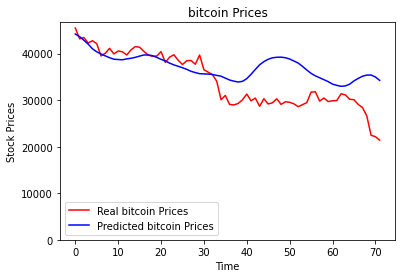

In [16]:

from tensorflow import keras
model = keras.models.load_model(f'LSTM_ARIMA_{stock}.h5')
predict_prices = model.predict(x_test)
predict_prices = scala_y.inverse_transform(predict_prices)
# trả về giá thực không còn scale nữa

# Ploting the Stat
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1, 1)
real_price = np.array(real_price)
real_price = real_price.reshape(real_price.shape[0], 1)

plt.plot(real_price, color="red", label=f"Real {stock} Prices")
plt.plot(predict_prices, color="blue", label=f"Predicted {stock} Prices")
plt.title(f"{stock} Prices")
plt.xlabel("Time")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()
plt.close()



In [17]:
index_test = np.array(df.index[len(df)-test_size:])
df_lstm = pd.DataFrame(index=index_test)
df_lstm.index.name='Date'
df_lstm['Actual'] = real_price
df_lstm['LSTM'] = predict_prices
df_lstm['Error'] = real_price - predict_prices
df_lstm

,Actual,LSTM,Error
Date,,,
2022-04-05,45506.0,44212.253906,1293.746094
2022-04-06,43173.0,43661.000000,-488.000000
2022-04-07,43448.0,42866.390625,581.609375
2022-04-08,42275.0,42044.718750,230.281250
2022-04-09,42767.0,41033.218750,1733.781250
...,...,...,...
2022-06-11,28403.4,35134.921875,-6731.521875
2022-06-12,26606.3,35387.933594,-8781.633594
2022-06-13,22448.0,35396.917969,-12948.917969


Hàm kiểm định chuỗi dừng

In [18]:
df_arima = df_lstm.copy()
df_arima=df_arima.drop(columns=['Actual', 'LSTM'])
print(df_arima)

                   Error
Date                    
2022-04-05   1293.746094
2022-04-06   -488.000000
2022-04-07    581.609375
2022-04-08    230.281250
2022-04-09   1733.781250
...                  ...
2022-06-11  -6731.521875
2022-06-12  -8781.633594
2022-06-13 -12948.917969
2022-06-14 -12822.196094
2022-06-15 -12850.333594

[72 rows x 1 columns]


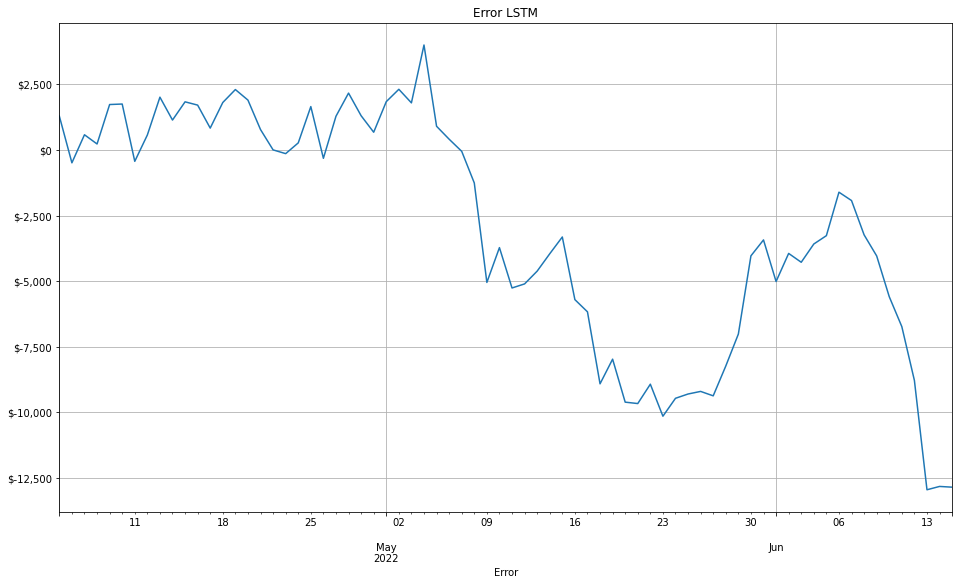

In [19]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Error LSTM'
xlabel = 'Error'

ax = df_arima['Error'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [20]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

Kiểm định tính dừng của chuỗi

In [21]:
adf_test(df_arima,'Error Bitcoin Price')

Augmented Dickey-Fuller Test: Error Bitcoin Price
ADF test statistic        -0.502193
p-value                    0.891588
Number of lags used        0.000000
Number of observations    71.000000
critical value (1%)       -3.526005
critical value (5%)       -2.903200
critical value (10%)      -2.588995
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

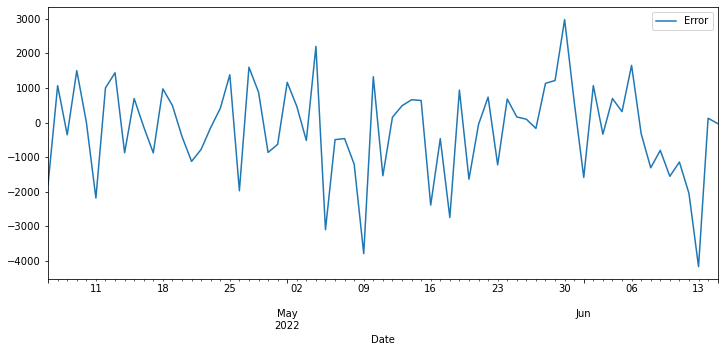

In [22]:
diff_1 = df_arima.diff().dropna()
diff_1.plot(figsize=(12,5));

Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [23]:
adf_test(diff_1, 'Error Bitcoin Price First Difference')

Augmented Dickey-Fuller Test: Error Bitcoin Price First Difference
ADF test statistic       -8.690181e+00
p-value                   4.060548e-14
Number of lags used       0.000000e+00
Number of observations    7.000000e+01
critical value (1%)      -3.527426e+00
critical value (5%)      -2.903811e+00
critical value (10%)     -2.589320e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [24]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [25]:
arima_model = ArimaModel(df_arima)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1264.812, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1237.574, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1262.824, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1227.677, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1226.231, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=1227.574, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1224.228, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1225.676, Time=0.01 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=1225.602, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.11 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:               SARIMAX(3, 2, 0)   Log Likelihood                -608.114
Date:                Wed, 15 Jun 2022   AIC                           1224.228
Time:                        22:56:58   BIC                           1233.222
Sample:                             0   HQIC                          1227.801
                                 - 72                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9092      0.129     -7.065      0.000      -1.161      -0.657
ar.L2         -0.5994      0.171     -3.503      0.000      -0.935      -0.264
ar.L3         -0.2285      0.137     -1.663      0.096      -0.498       0.041
sigma2      2.079e+06   3.86e+05      5.384      0.000    1.32e+06    2.84e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.90
Prob(Q):                              0.92   Prob(JB):                         0.23
Heteroskedasticity (H):               1.48   Skew:                            -0.48
Prob(H) (two-sided):                  0.35   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Dự đoán trên tập test

In [26]:
pred = arima_model.predict(len(df_arima))
df_pred=pd.DataFrame(index=df_arima.index )
df_pred.index.name='Date'
df_pred['Error']=pred
print(df_pred)


                   Error
Date                    
2022-04-05 -14827.574206
2022-04-06 -15921.163879
2022-04-07 -16614.540286
2022-04-08 -17756.001594
2022-04-09 -18931.882395
...                  ...
2022-06-11 -85126.831802
2022-06-12 -86178.748825
2022-06-13 -87230.665848
2022-06-14 -88282.582871
2022-06-15 -89334.499893

[72 rows x 1 columns]


Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

Vẽ đồ thị cho tập test và kết quả dự đoán

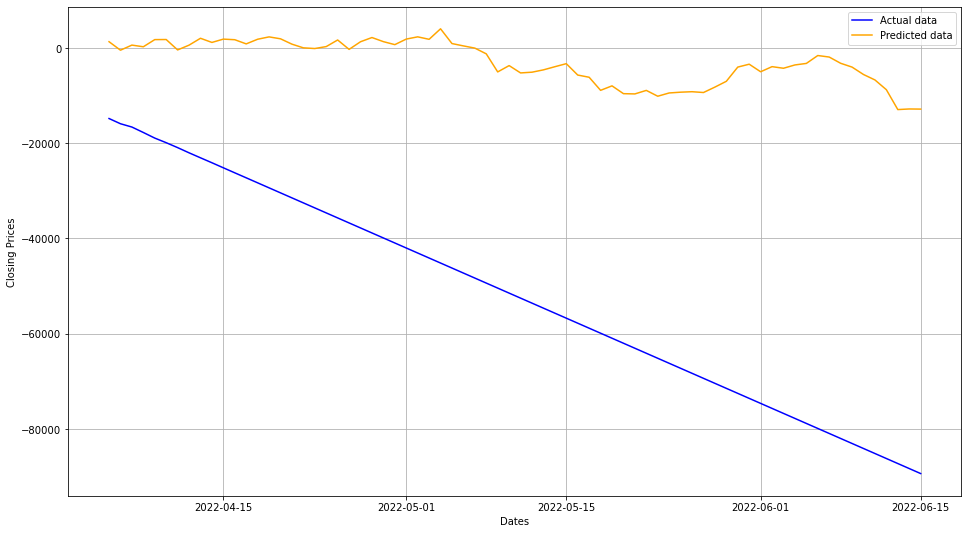

In [27]:
# pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_pred, 'blue', label='Actual data')
plt.plot(df_arima, 'orange', label='Predicted data')
plt.legend()

Đánh giá mô hình

In [28]:
mae = mean_absolute_error(df_arima, df_pred)
mape = mean_absolute_percentage_error(df_arima, df_pred)
mse = mean_squared_error(df_arima, df_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")



MAE: 49046.82
MAPE: 12835.85%
MSE: 2754048102.74
RMSE: 52479.03


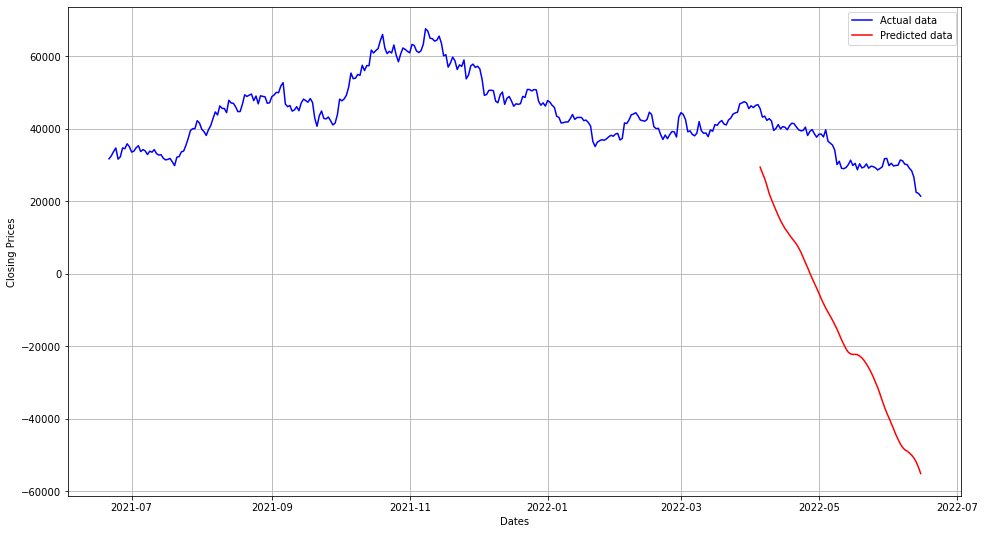

In [29]:

formatter = ticker.StrMethodFormatter('${x:,.0f}')
title = stock.upper()+'Price'
ylabel = 'USDT'
xlabel = 'Date'
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df['Close'], 'blue', label='Actual data')
plt.plot(df_lstm['LSTM']+df_pred['Error'], 'red', label='Predicted data')
plt.legend()

In [30]:
y_model = df_lstm.copy()
y_model['Final_LSTM'] = df_lstm['LSTM'] + df_pred['Error']
y_model

,Actual,LSTM,Error,Final_LSTM
Date,,,,
2022-04-05,45506.0,44212.253906,1293.746094,29384.679700
2022-04-06,43173.0,43661.000000,-488.000000,27739.836121
2022-04-07,43448.0,42866.390625,581.609375,26251.850339
2022-04-08,42275.0,42044.718750,230.281250,24288.717156
2022-04-09,42767.0,41033.218750,1733.781250,22101.336355
...,...,...,...,...
2022-06-11,28403.4,35134.921875,-6731.521875,-49991.909927
2022-06-12,26606.3,35387.933594,-8781.633594,-50790.815231
2022-06-13,22448.0,35396.917969,-12948.917969,-51833.747879
